In [0]:
import os
img_dir = '/tmp/nst'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg

In [0]:
!ls

sample_data


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import backend as K

from IPython.display import display
from PIL import Image
import time
import functools

In [27]:
tfe.enable_eager_execution()
print("Eager execution: {}".format(tfe.executing_eagerly()))

Eager execution: True


In [0]:
def load_img(path):
  img = Image.open(path)
  scale = 512 / max(img.size)
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  img = kp_image.img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  return img

In [0]:
def im_show(img, title = None):
  img = np.squeeze(img, axis = 0)
  img = img.astype('uint8')
  plt.imshow(img)
  if title is not None:
    plt.title(title)
  plt.imshow(img)

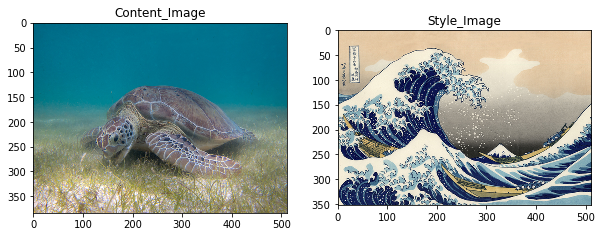

In [30]:
plt.figure(figsize = (10, 10))

content_path = '/tmp/nst/Green_Sea_Turtle_grazing_seagrass.jpg'
style_path = '/tmp/nst/The_Great_Wave_off_Kanagawa.jpg'

content = load_img(content_path)
style = load_img(style_path)

plt.subplot(1,2,1)
im_show(content, "Content_Image")
plt.subplot(1,2,2)
im_show(style, "Style_Image")
plt.show()

# **Prepare Data**

In [0]:
def load_and_prepare_img(img_path):
  img = load_img(img_path)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [0]:
def depreprocess(img):
  x = img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, axis = 0)
  if len(x.shape) != 3:
    raise ValueError("Invalid Image")
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
  
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [33]:
model = tf.keras.applications.vgg19.VGG19(include_top = False, weights = 'imagenet')

80142336/80134624 [==============================] - 2s 0us/step


In [39]:
for layer in model.layers:
  print("Layer : {}    Layer Name : {}".format(layer, layer.name))

Layer : <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9c1782ada0>    Layer Name : input_1
Layer : <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9c52fa2710>    Layer Name : block1_conv1
Layer : <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9c17822b70>    Layer Name : block1_conv2
Layer : <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9c17822fd0>    Layer Name : block1_pool
Layer : <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9c17860898>    Layer Name : block2_conv1
Layer : <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9c177fc0b8>    Layer Name : block2_conv2
Layer : <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9c1789e6a0>    Layer Name : block2_pool
Layer : <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9c1789e7f0>    Layer Name : block3_conv1
Layer : <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9c

In [0]:
content_blocks = ['block5_conv2']

style_blocks = ['block1_conv1',
               'block2_conv1',
               'block3_conv1',
               'block4_conv1',
               'block5_conv1'
              ]
num_content_layers = len(content_blocks)
num_style_layers = len(style_blocks)

In [0]:
def get_model():
  vgg = tf.keras.applications.vgg19.VGG19(include_top = False, weights = 'imagenet')
  vgg.trainable = False
  style_output = [vgg.get_layer(name).output for name in style_blocks]
  content_output = [vgg.get_layer(name).output for name in content_blocks]
  model_ouputs = style_output + content_output
  return models.Model(vgg.input, model_output)

In [0]:
def get_content_loss(base_content, predicted_content):
  return tf.reduce_mean(tf.square(base_content - predicted_content))

In [0]:
def gram_conv(input_tensor):
  channels = int(input_tensor.shape[-1])
  input_tensor = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(input_tensor)[0]
  gram = tf.matmul(input_tensor, input_tensor, transpose_a=True)
  return (gram / tf.cast(n, tf.float32))

def get_style_loss(base_style, predicted_style):
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_conv(base_style)
  return tf.reduce_mean(tf.square(gram_style - predicted_style)) / (4 * (channels**2) * ((height * width)**2))

In [0]:
def compute_loss(model, input_image, loss_weight, ):
  style_weight, content_weight = loss_weight
  model_outputs = model(input_image)
  
  style_output = model_output[:num_style_layers]
  content_output = model_output[num_style_layers:]
  
  style_score = 0.0
  content_score = 0.0
  
  weight_style = 1.0 / float(num_style_layers)
  for target_style, pred_style in zip(gram_style_features, style_output):
    style_score += (get_style_loss(target_style, pred_style) * weight_style)
  
  weight_content = 1.0 / float(num_content_layers)
  for target_content, pred_content in zip(gram_content_features, content_output):
    content_score += (get_content_loss(target_content, pred_content) * weight_content)
  
  total_score = style_weight * style_score + content_weight * content_score
  
  return total_score, content_score, style_score